In [ ]:
# Step 1: Install Required Packages
!pip install kaggle tensorflow keras
!pip install tensorflow
!pip install kaggle tensorflow keras torch torchvision

In [1]:
import os
import zipfile
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torchvision import models as torch_models, transforms
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
# Step 1: Download the dataset
dataset_name = "datamunge/sign-language-mnist"
!kaggle datasets download -d {dataset_name}  # Download the dataset from Kaggle


Dataset URL: https://www.kaggle.com/datasets/datamunge/sign-language-mnist
License(s): CC0-1.0
 99% 62.0M/62.6M [00:02<00:00, 43.4MB/s]
100% 62.6M/62.6M [00:02<00:00, 31.5MB/s]


In [3]:
# Step 2: Extract the dataset
zip_file = "sign-language-mnist.zip"  # Name of the downloaded zip file
dataset_dir = "/content/sign_language_mnist"  # Directory to extract the dataset
# Check if the dataset directory exists, if not, create it and extract the zip file
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)  # Create the directory if it doesn't exist

# Extract the zip file
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(dataset_dir)  # Extract all contents to the specified directory

In [4]:
# Step 3: Load the dataset
# Load the training and test data
train_data = pd.read_csv(os.path.join(dataset_dir, 'sign_mnist_train.csv'))
test_data = pd.read_csv(os.path.join(dataset_dir, 'sign_mnist_test.csv'))

In [5]:
# Step 4: Preprocess the data
# Separate labels and pixel values
X_train = train_data.drop('label', axis=1).values  # Drop the label column
y_train = train_data['label'].values  # Get the labels
X_test = test_data.drop('label', axis=1).values  # Drop the label column
y_test = test_data['label'].values  # Get the labels

# Normalize pixel values to [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Resize the data to 32x32 images
X_train = X_train.reshape(-1, 28, 28, 1)  # Reshape to (num_samples, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)  # Reshape to (num_samples, 28, 28, 1)

# Resize images to 32x32
X_train = tf.image.resize(X_train, [32, 32]).numpy()  # Resize to (num_samples, 32, 32, 1)
X_test = tf.image.resize(X_test, [32, 32]).numpy()  # Resize to (num_samples, 32, 32, 1)

# Convert grayscale to RGB
X_train = np.repeat(X_train, 3, axis=-1)  # Convert to (num_samples, 32, 32, 3)
X_test = np.repeat(X_test, 3, axis=-1)  # Convert to (num_samples, 32, 32, 3)

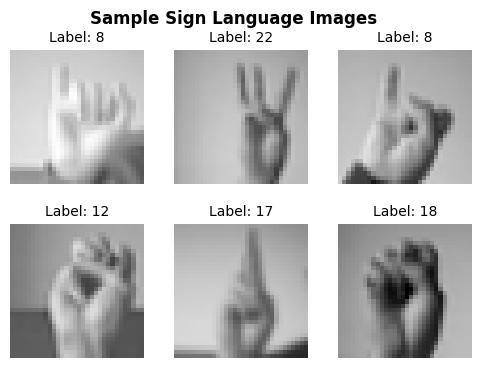

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Step 3.1: Visualize some images from the dataset
def plot_images(images, labels, num_images=6):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(6, 4))  # Smaller figure size
    fig.suptitle("Sample Sign Language Images", fontsize=12, fontweight="bold")  # Title

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap='gray')
        ax.set_title(f'Label: {labels[i]}', fontsize=10)
        ax.axis('off')  # Hide axes for clarity

    plt.subplots_adjust(hspace=0.3, wspace=0.2)  # Adjust spacing
    plt.show()

# Display 6 random images from the training set
random_indices = np.random.choice(len(X_train), size=6, replace=False)
plot_images(X_train[random_indices], y_train[random_indices])

In [7]:
# Step 5: Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)

In [9]:
# Step 6: Build the model using ResNet-50 and LSTM
def create_model():
    # Load ResNet50 as a feature extractor
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    base_model.trainable = False  # Initially freeze the base model

    # Create the model
    model = models.Sequential()
    model.add(base_model)  # Add ResNet50
    model.add(layers.GlobalAveragePooling2D())  # Global average pooling to reduce dimensions
    model.add(layers.BatchNormalization())  # Add Batch Normalization
    model.add(layers.RepeatVector(1))  # Repeat the feature vector for LSTM input
    model.add(layers.LSTM(256, return_sequences=True))  # First LSTM layer
    model.add(layers.BatchNormalization())  # Batch Normalization
    model.add(layers.LSTM(128, return_sequences=False))  # LSTM layer
    model.add(layers.BatchNormalization())  # Add Batch Normalization
    model.add(layers.Dense(26, activation='softmax'))  # Output layer for 26 classes
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


# Create and train the model
model = create_model()

# Early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Calculate steps per epoch
batch_size = 32
steps_per_epoch = len(X_train) // batch_size

# Fit the model using data augmentation with increased epochs
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    epochs=50,  # Increased epochs to 30
                    validation_data=(X_test, y_test),
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[early_stopping, lr_reduction])

Epoch 1/50
857/857 ━━━━━━━━━━━━━━━━━━━━ 62s 48ms/step - accuracy: 0.4896 - loss: 1.6937 - val_accuracy: 0.7695 - val_loss: 0.6286 - learning_rate: 0.0010
Epoch 2/50
857/857 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6875 - loss: 0.8552 - val_accuracy: 0.7727 - val_loss: 0.6246 - learning_rate: 0.0010
Epoch 3/50
857/857 ━━━━━━━━━━━━━━━━━━━━ 42s 49ms/step - accuracy: 0.7521 - loss: 0.7479 - val_accuracy: 0.8219 - val_loss: 0.5064 - learning_rate: 0.0010
Epoch 4/50
857/857 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9062 - loss: 0.3628 - val_accuracy: 0.8222 - val_loss: 0.5132 - learning_rate: 0.0010
Epoch 5/50
857/857 ━━━━━━━━━━━━━━━━━━━━ 75s 45ms/step - accuracy: 0.8182 - loss: 0.5540 - val_accuracy: 0.8603 - val_loss: 0.3669 - learning_rate: 0.0010
Epoch 6/50
857/857 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8438 - loss: 0.4709 - val_accuracy: 0.8610 - val_loss: 0.3690 - learning_rate: 0.0010
Epoch 7/50
857/857 ━━━━━━━━━━━━━━━━━━━━ 81s 47ms/step - accuracy: 0.8446 - loss: 0

225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9785 - loss: 0.0758
Test Accuracy: 98.01%


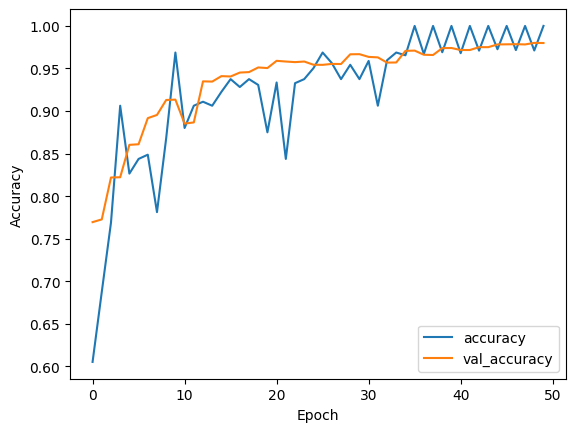

In [14]:
# Step 7: Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


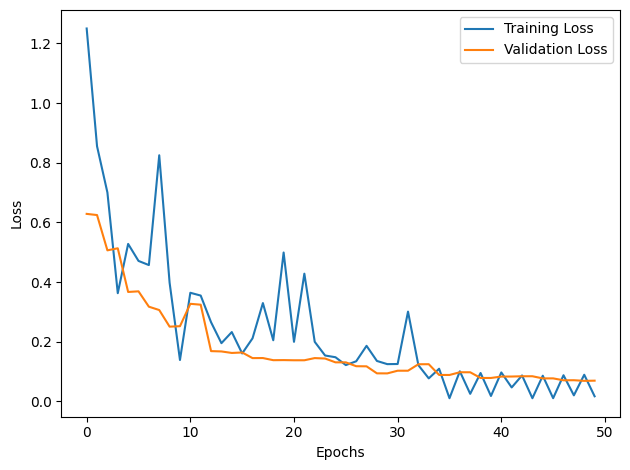

In [17]:
# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()



In [18]:
# Step 9: Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}')  # Print test loss
print(f'Test Accuracy: {accuracy * 100:.2f}%')  # Print test accuracy

# Print validation loss and accuracy from the training history
val_loss = history.history['val_loss'][-1]  # Get the last validation loss
val_accuracy = history.history['val_accuracy'][-1]  # Get the last validation accuracy
print(f'Validation Loss: {val_loss:.4f}')  # Print validation loss
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')  # Print validation accuracy

225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9785 - loss: 0.0758
Test Loss: 0.0690
Test Accuracy: 98.01%
Validation Loss: 0.0696
Validation Accuracy: 97.99%


225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step


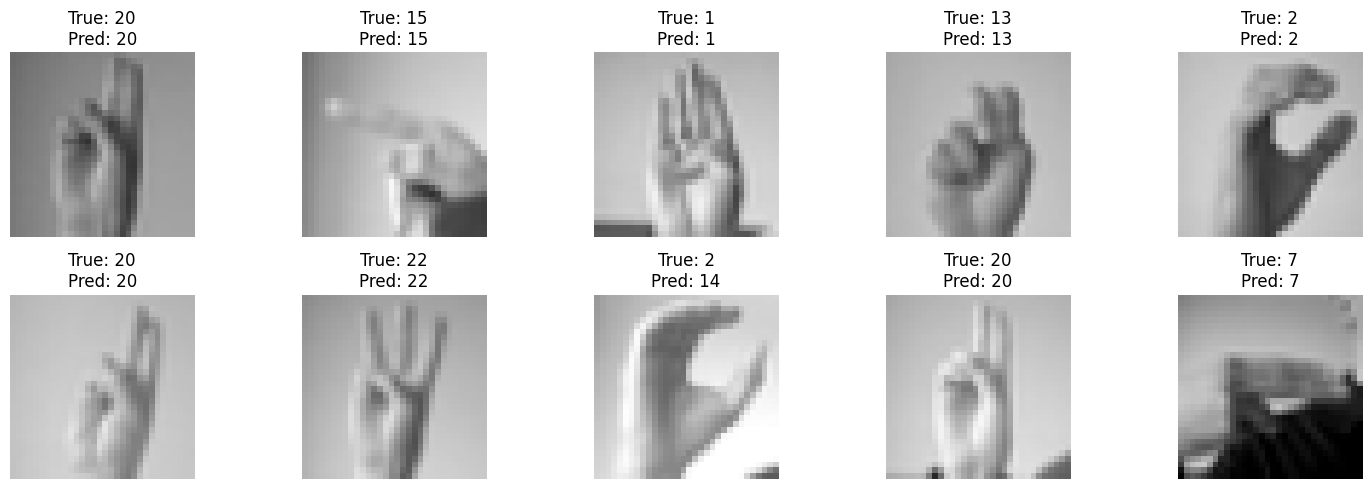

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       331
           1       1.00      0.98      0.99       432
           2       1.00      0.98      0.99       310
           3       1.00      0.93      0.96       245
           4       0.97      1.00      0.98       498
           5       1.00      1.00      1.00       247
           6       0.94      0.98      0.96       348
           7       1.00      0.95      0.98       436
           8       0.96      1.00      0.98       288
          10       0.99      1.00      0.99       331
          11       0.92      1.00      0.96       209
          12       0.99      0.93      0.96       394
          13       0.95      0.98      0.96       291
          14       0.98      1.00      0.99       246
          15       1.00      1.00      1.00       347
          16       1.00      1.00      1.00       164
          17       0.87      1.00      0.93       144
   

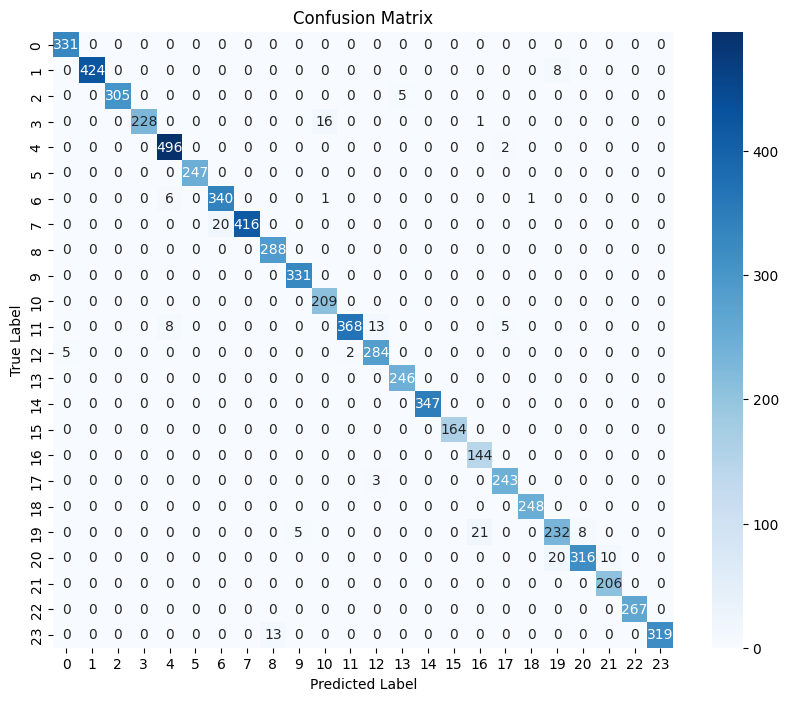

In [ ]:
# Step 7.1: Visualize some test images with their predictions
def plot_test_images(images, true_labels, predicted_labels, num_images=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f'True: {true_labels[i]}\nPred: {predicted_labels[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Get predictions for the test set
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)  # Get the class with the highest probability

# Display 10 random test images with their true and predicted labels
random_indices = np.random.choice(len(X_test), size=10, replace=False)
plot_test_images(X_test[random_indices], y_test[random_indices], predicted_labels[random_indices])

# Generate a classification report
report = classification_report(y_test, predicted_labels)
print("Classification Report:\n", report)

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 1, 1, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_5 (RepeatVector)       │ (None, 1, 2048)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 1, 256)              │       2,360,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 1, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 128)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 26)                  │           3,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,289,552 (119.36 MB)

 Trainable params: 2,565,658 (9.79 MB)

 Non-trainable params: 23,592,576 (90.00 MB)

 Optimizer params: 5,131,318 (19.57 MB)

In [ ]:
!pip install opencv-python

In [ ]:
def create_3d_model():
    # Load a 3D CNN as a feature extractor
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 32, 3))
    base_model.trainable = True  # Unfreeze the base model for fine-tuning

    # Create the model
    model = models.Sequential()
    model.add(base_model)  # Add ResNet50
    model.add(layers.GlobalAveragePooling3D())  # Global average pooling to reduce dimensions
    model.add(layers.Dense(26, activation='softmax'))  # Output layer for 26 classes

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
def get_3d_cam(model, img, class_index):
    # Convert the image to a tensor and add a batch dimension
    img_tensor = tf.convert_to_tensor(img)
    img_tensor = tf.expand_dims(img_tensor, axis=0)  # Shape: (1, depth, height, width, channels)

    with tf.GradientTape() as tape:
        # Make a prediction
        tape.watch(img_tensor)
        predictions = model(img_tensor)
        loss = predictions[0, class_index]  # Get the score for the target class

    # Compute the gradients of the loss with respect to the input image
    grads = tape.gradient(loss, img_tensor)[0]  # Shape: (depth, height, width, channels)

    # Generate the CAM
    weights = tf.reduce_mean(grads, axis=(0, 1, 2))  # Global average pooling
    cam = tf.reduce_sum(tf.multiply(weights, img_tensor[0]), axis=-1)  # Shape: (height, width)

    # Post-process CAM for visualization
    cam = tf.maximum(cam, 0)  # Apply ReLU
    cam = cam / tf.reduce_max(cam)  # Normalize
    return cam.numpy()

In [ ]:
def display_3d_cam(images, true_labels, predicted_labels):
    num_images = len(images)

    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i][:, :, 0], cmap='gray')  # Display the first channel of the image
        plt.title(f'True: {true_labels[i]}\nPred: {predicted_labels[i]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        cam = get_3d_cam(model, images[i], predicted_labels[i])
        plt.imshow(cam, cmap='magma')
        plt.title(f'3D CAM\nPred: {predicted_labels[i]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

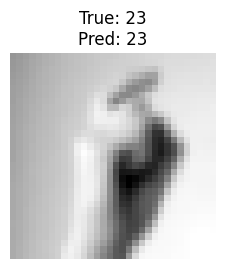

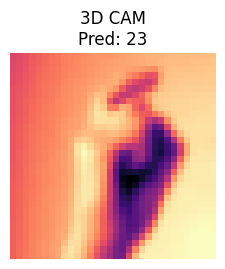

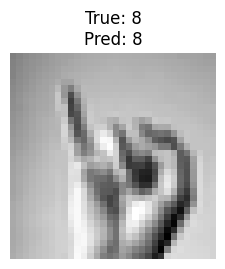

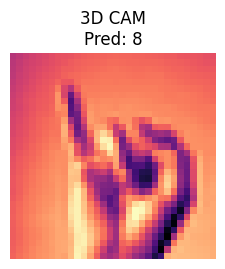

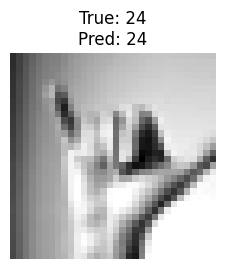

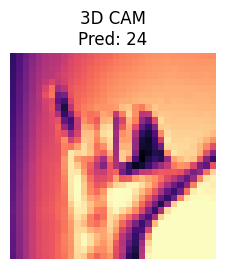

In [ ]:
# Example usage for 3D CAMs
for i in range(3):
    random_index = np.random.choice(len(X_test))
    img = X_test[random_index]
    true_label = y_test[random_index]
    predicted_label = np.argmax(predictions[random_index])  # Get the predicted label

    # Display the original image and its 3D CAM
    display_3d_cam([img], [true_label], [predicted_label])